## **Artificial Neural Networks**

Import libraries

In [ ]:
# pytorch가 전세계적으로 가장 많이 사용되는 라이브러리. 한국에서는 tensorflow가 많이 사용된다.
import torch
import torch.nn as nn
import torch.nn.functional as F # 직접 작성한 활성화, 손실 함수를 F.000으로 대체하는 것
import torchvision # 효율적인 이미지 및 비디오 변환을위한 유틸리티, dataset 불러오기
import torchvision.transforms as transforms # 일반적인 이미지 변환이며, .compose를 붙여서 사용할 수 있다.
from torchsummary import summary

**MNIST dataset**

*   Database of handwritten digits
*   Training set: 60,000 samples
*   Testing set: 10,000 samples
*   10 classes of 28 x 28 images (1 channel, grayscale)

![alt text](https://drive.google.com/uc?id=1hZrTmIUAYpfwWJp_wRYs3I6VwIlhVbnZ)

Load training and test dataset

.MNIST
- 0-9까지의 손글씨 숫자 이미지

torch.utils.data.DataLoader
- PyTorch 데이터 불러오기 기능의 핵심, 데이터를 파이썬 iterable로써 접근할 수 있게 해주는 클래스.
- DataLoader : data를 공급해주는 역할 (batch_size : 몇개씩 넣을껀지 / shuffle : 섞으면서 넣을껀지 / transform : data에 일정수준 변형을 줄 것인지 -일부 회전하거나, 크기를 변경)

In [ ]:
BATCH_SIZE = 32 # training data를 32개로 잘라서 사용

## transformations : 여러 transform 들을 Compose로 구성할 수 있습니다.
transform = transforms.Compose([transforms.ToTensor()]) # .ToTensor() : 데이터 타입을 Tensor 형태로 변경

## download and load training dataset
# 경로, 어떤 데이터로 가져올껀지, 경로에 없으면 다운로드 해라, transform
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# torch.utils.data.DataLoader : PyTorch 데이터 불러오기 기능의 핵심, 데이터를 파이썬 iterable로써 접근할 수 있게 해주는 클래스
# 가져올 데이터, batch 크기, batch 가져올때 랜덤으로 가져올지, 데이터 로딩에 사용하는 subprocess개수
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

## download and load testing dataset
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [ ]:
print(mnist_trainset)
print(mnist_testset)

Visualize MNIST dataset
 - 실제 어떻게 생겼는지 시각화해보자.
 
 [iter, next](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=youndok&logNo=222073036603)
 
 iterable
 - python에서 'iterable하다'는 건 뜻 그대로 '반복가능한 것'을 의미(객체에 적용)
 - 반복 가능한 객체는 string, list, tuple, dict, set, range가 있습니다.

 iterator
 - iterable한 객체가 iter()를 통과하여 "~_iterator" 형태의 객체로 생성된 것
 - 한번에 하나씩 그 객체에 access할 수 있습니다.
 - iterator는 순서대로 자료를 가져온 이후 `그 데이터는 폐기해 버리기` 때문에, 메모리 사용에 제약이 따르는 대규모 데이터처리에 매우 효과적입니다.
 - next로 가져올 수 있다.
 
.make_grid
- 이미지 훈련시킬 때 중간 결과가 어떻게 나오는지 확인하고 싶을때 유용, grid tensor로 만들기

.transpose
- 벡터를 변환시켜줌

.numpy()
- converter form torch.Tensor to numpy array

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## get some random training images
mnist_dataiter = iter(mnist_trainloader)
images, labels = mnist_dataiter.next()

## show images
images_grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
# data의 형태
# image : 글씨 image data / label : class
for images, labels in mnist_trainloader:
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

for images, labels in mnist_testloader:
    print("Test - image batch dimensions:", images.shape)
    print("Test - image label dimensions:", labels.shape)
    break

# image shape : batch size 32, channel 1(gray scale이면 0~255까지 값을 하나 가짐), 가로 28, 세로 28
# label shape : data 32개에 대한 32개의 class data

Create a simple model

nn.Module
- 모든 뉴럴 네트워크 모듈의 기본 클래스이다. 일반적인 모델들은 이 클래스를 상속받아야한다. 모듈들은 다른 모듈을 또 포함할 수 있다.

시작
- 만들어진 것을 실행하면 forward가 실행됨

- x 입력이 일어나면
- convlayer를 통과 <- in_channels:1(grayscale), out_channels:32(32개의 서로 다른 kernel을 사용), kernel size:3(3*3)
- activation layer인 relu를 통과
- flatten (matrix 형태의 image data를 vector 형태로 변환)
- fully-connected layer (1) <- input:32*26*26, output:128 (28에서 26이 되는 이유는 kernel size가 3이어서... 3*3이 28칸을 움직이니까 output이 26) = convolution 연산의 특징)
- activation
- fully-connected layer (2) <- input:128, output:10 (classification 진행)
- softmax < 확률을 probability로 변환
- = 최종 출력값

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.convlayer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.fclayer1 = nn.Linear(26 * 26 * 32, 128)
        self.fclayer2 = nn.Linear(128, 10)

    def forward(self, x):
        # input: 32x1x28x28 -> output: 32x32x26x26
        x = self.convlayer(x)
        x = F.relu(x)

        # input: 32x32x26x26 -> output: 32x(32*26*26)
        x = x.flatten(start_dim = 1)

        # input: 32x(32*26*26) -> output: 32x128
        x = self.fclayer1(x)
        x = F.relu(x)

        # input: 32x128 -> output: 32x10 (32 images, 10 classes)
        logits = self.fclayer2(x)
        out = F.softmax(logits, dim=1)
        return out

Test if the model works well
- train을 안해서 아직 classification은 안됨.
- input, output size 확인하는 단계.
- 32개의 data에 각각 10개의 class에 대한 probability 값이 생긴다.

In [ ]:
model = SimpleModel()
for images, labels in mnist_trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

In [ ]:
summary(model, input_size=(1,28,28))

Let's train the model

train model
- model, crirerion:error 어떻게 계산할껀지, optimizer:학습을 어떻게 진행할껀지(ex. gradient), trainloader:데이터 줌, device:cpu? gpu?, num_epochs:epoch수

[enumerate](https://www.daleseo.com/python-enumerate/)
- for 루프는 기본적으로 for <원소> in <목록>:
- enumerate() 함수는 기본적으로 인덱스와 원소로 이루어진 터플(tuple)을 만들어줍니다.



In [ ]:
## compute stat
def compute_stat(outputs, labels, stats):
    _, preds = torch.max(outputs, 1) # 가장 큰 값을 찾아냄
    stats['n_corr'] += torch.sum(preds == labels).item() # dict의 key와 value 쌍을 얻을 수 있다.
    stats['n'] += torch.numel(labels) # input tensor의 총 요소 수를 반환합니다

    return stats

def train_model(model, criterion, optimizer, trainloader, device, num_epochs=25):
  epoch_stat = {'n_corr': 0, 'n': 0}

  for epoch in range(num_epochs):
      train_running_loss = 0.0
      train_acc = 0.0

      model.train()  # Set model to training mode

      ## training step / batch 하나씩 처리하는 for문
      for i, (images, labels) in enumerate(trainloader):
          
          images = images.to(device) # cpu에서 gpu로 data 넘김
          labels = labels.to(device)

          ## forward + backprop + loss
          optimizer.zero_grad() # grdient 계산된 것이 optimizer에 더해지는 방식으로 계산되는데, 새로운 배치에서는 초기 상태로 만들어줘야 한다.
          outputs = model(images) # feed forward
          loss = criterion(outputs, labels) # 오차 = 어떻게 계산할껀지 정한거(예측치, 실제 정답)
          loss.backward() # loss에 따라 gradient가 계산됨

          ## update model params
          optimizer.step() # weight 값들이 조절됨

          train_running_loss += loss.detach().item() # detach() 메서드는 그래디언트가 필요하지 않다고 선언된 텐서에 새 뷰를 생성. 에러값이 어떻게 계산되었는지 확인하기위해 더하주고 있음
          epoch_stat = compute_stat(outputs, labels, epoch_stat) # 얼마나 정답인지 등 stat 표기.
      
      model.eval() # evaluation(평가) mode로 전환
      print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_running_loss / i, epoch_stat['n_corr'] / epoch_stat['n'] * 100)) 
      
  return model

In [ ]:
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = SimpleModel()
model = model.to(device) # cpu에서 gpu로 data 넘김

## loss function
criterion = nn.CrossEntropyLoss() 
## optimization. 신경망 파라메터를 optimizer에 전달해 줄 때, torch.nn.Module 클래스의 parameters() 메소드를 사용한다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)# stochastic gradient descent(.parameters:weight들을 알려줌 / lr:learning_rate / momentum:관성, 가속도 개념)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam : RMSprop + Momentum

In [ ]:
model = train_model(model, criterion, optimizer, mnist_trainloader, device, num_epochs=5)

Test on the test dataset

In [ ]:
model.eval() # Set model to evaluate mode

test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(mnist_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))

## **Utilize the existing models & transfer learning**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

**CIFAR10 dataset**

*   Database of natural images
*   Training set: 50,000 samples
*   Testing set: 10,000 samples
*   10 classes of 32 x 32 images

![alt text](https://drive.google.com/uc?id=1qQFYheGrOa3Rj3nlcf2UXo26yTSwu6Ak)

Load CIFAR10 dataset

In [2]:
BATCH_SIZE = 64

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=1)

## download and load testing dataset
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


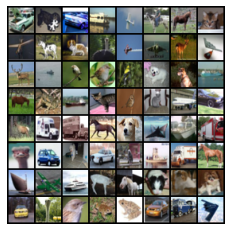

In [3]:
import matplotlib.pyplot as plt
import numpy as np

## get some random training images
dataiter = iter(cifar_trainloader)
images, labels = dataiter.next()

## show images
images_grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [4]:
for images, labels in cifar_trainloader:
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

for images, labels in cifar_testloader:
    print("Test - image batch dimensions:", images.shape)
    print("Test - image label dimensions:", labels.shape)
    break

Train - image batch dimensions: torch.Size([64, 3, 32, 32])
Train - image label dimensions: torch.Size([64])


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test - image batch dimensions: torch.Size([64, 3, 32, 32])
Test - image label dimensions: torch.Size([64])


Load the existing model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load the existing model (Resnet18) 
# pretrained model: use weights from ImageNet dataset(선 학습된 weight 가져온다.)
model_ft = models.resnet18(pretrained=True)
model_ft = model_ft.to(device)

In [6]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
summary(model_ft, input_size=(3,32,32)) 
# 진행될수록 channel은 늘고, pooling하기 때문에 가로세로는 줄어든다.
# 마지막에 1000이 되는 이유는, imagenet class가 1000개여서

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Check the last fully-connected (fc) layer

In [8]:
print(model_ft.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [9]:
fc_num_in_fts = model_ft.fc.in_features
fc_num_out_fts = model_ft.fc.out_features

print('LAST - fc: ', fc_num_in_fts, fc_num_out_fts)
# 마지막 출력값인 (fc) 형태를 변경해아한다.

LAST - fc:  512 1000


Change 'fc' to fit to CIFAR19 dataset

In [12]:
# .Linear : fully-connected layer
model_ft.fc = nn.Linear(fc_num_in_fts, 10)  # in 512, out 10으로 수정된 새로운 layer를 넣어준다.

In [13]:
model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Let's train the model

In [ ]:
# 마지막 layer는 우리가 class를 1000개에서 10개로 줄였기 때문에 weight 값이 임의로 설정되어있다. = 학습을 다시 해야함.(앞에서 사용한 model을 이용해보자)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## loss function
criterion_ft = nn.CrossEntropyLoss()
## optimization
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)

model_ft = train_model(model_ft, criterion_ft, optimizer_ft, cifar_trainloader, device, num_epochs=5)

Test on the test dataset

In [ ]:
test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(cifar_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))

Change 'conv1' and 'fc' to fit to MNIST dataset
- 입력 channel 변경 : model이 color 인거에 맞춰져 있어서 1channel(grayscale)로 맞춰줘야한다.

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load the existing model (Resnet18) 
# pretrained model: use weights from ImageNet dataset
model_ft2 = models.resnet18(pretrained=True)
model_ft2 = model_ft2.to(device)

In [15]:
print(model_ft2.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [16]:
conv1_num_in_fts2 = model_ft2.conv1.in_channels
conv1_num_out_fts2 = model_ft2.conv1.out_channels

print('FIRST - conv1 : ', conv1_num_in_fts2, conv1_num_out_fts2)

fc_num_in_fts2 = model_ft2.fc.in_features
fc_num_out_fts2 = model_ft2.fc.out_features

print('LAST - fc: ', fc_num_in_fts2, fc_num_out_fts2)

FIRST - conv1 :  3 64
LAST - fc:  512 1000


In [17]:
# in 1, out 64로 맞춤.
model_ft2.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3, bias=False)

model_ft2.fc = nn.Linear(fc_num_in_fts2, 10)  # 10 classes

In [ ]:
model_ft2 = model_ft2.to(device)
summary(model_ft2, input_size=(1,28,28))

In [ ]:
## loss function
criterion_ft2 = nn.CrossEntropyLoss()
## optimization
#optimizer_ft2 = optim.SGD(model_ft2.parameters(), lr=1e-2, momentum=0.9)
optimizer_ft2 = optim.Adam(model_ft2.parameters(), lr=1e-3)

model_ft2 = train_model(model_ft2, criterion_ft2, optimizer_ft2, mnist_trainloader, device, num_epochs=5)

# error가 떨어지는 curve가 중요한데, 한번에 확 떨어져도 문제다. 적당한 속도로 개선되어야 좋다.
# curve가 어떻게 변하는지 보고 학습방향을 어떻게 가져갈건지 본인만의 know-how를 engineer에게 요구한다.

In [ ]:
test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(mnist_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft2(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))